# Simple autoencoder for DepMap dataset only
Apapted from the sample code provided along with the paper

Use mse loss

With Weights and Bias watch


In [1]:
import wandb
wandb.login()

wandb: Currently logged in as: kemingzhang. Use `wandb login --relogin` to force relogin


True

In [2]:
import torch
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import r2_score
import torch.nn as nn
import numpy as np
import pandas as pd
import scanpy as sc

from dataset import FasterDepMapDataset

In [3]:
config = dict(
    EPOCHS = 50,
    BATCH_SIZE = 1e3,
    LEARNING_RATE = 1e-3,
    NUM_LAYERS = 4,
)

In [4]:
#load the dataframe that contains one to one corresponding of gene id and gene index
gene_index_path = "gene_index.csv"
ds_path = "DepMap18Q3_gene_effect_mapped.tsv"
dataset = FasterDepMapDataset(ds_path, gene_index_path)

In [5]:
dataset.dataset

gene_id,cell_line,CERES_score,gene_idx,cell_line_idx
str,cat,f64,i64,i64
"""ENSG0000004736…","""RT11284_URINAR…",0.564074,920,460
"""ENSG0000017529…","""OVK18_OVARY""",0.805028,2379,423
"""ENSG0000010581…","""MCAS_OVARY""",-1.065476,12727,347
"""ENSG0000010968…","""T98G_CENTRAL_N…",0.223172,16715,249
"""ENSG0000013721…","""PF382_HAEMATOP…",0.09609,17182,419
"""ENSG0000014162…","""42MGBA_CENTRAL…",-0.803606,4831,132
"""ENSG0000012021…","""D283MED_CENTRA…",-0.11596,2752,25
null,"""HCC1806_BREAST…",-0.04869,19245,271
"""ENSG0000017037…","""ASPC1_PANCREAS…",2.231054,5143,77


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")


gene_index = pd.read_csv(gene_index_path)
gene_list = gene_index.gene_id.to_list()
n_genes = len(gene_list) #the number of total genes
n_samples = dataset.dataset["cell_line_idx"].unique().shape[0] #the number of samples
gene_emb_dim = 128 #the gene embedding dimension
sample_emb_dim = 64 #the sample embedding dimension


##sample embedding initialization parameters
sample_emb_init = torch.from_numpy(dataset.compute_sample_init_pca().astype('float32'))

In [7]:
class GeneEmbedding(nn.Module):
    def __init__(self, n_genes, gene_emb_dim, gene_list, gene_emb_init = None):
        super(GeneEmbedding, self).__init__()

        self.n_genes = n_genes
        self.gene_emb_dim = gene_emb_dim
        self.genes = gene_list

        """
        model the gene embedding as gaussian distributions computed from the mean embeddings and sd embeddings
        """
        if gene_emb_init is not None:
            self.emb_mu = nn.Embedding.from_pretrained(gene_emb_init, freeze = False)
        else:
            # init as [0, 1], as the dirichlet prior is in [0, 1]
            self.emb_mu = nn.Embedding.from_pretrained(
                torch.rand((n_genes, gene_emb_dim)), freeze = False
            )

        self.emb_log_sigma = nn.Embedding.from_pretrained(
            torch.full((n_genes, gene_emb_dim), np.log(0.5)), freeze = False
        )


    def get_emb_table(self):
        emb_df = pd.DataFrame(self.emb_mu.weight.detach().cpu(),
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.gene_emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df


    def get_log_sigma_table(self):
        emb_df = pd.DataFrame(self.emb_log_sigma.weight.detach().cpu(),
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.gene_emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df


    def get_shape(self):
        return (self.n_genes, self.gene_emb_dim)



In [8]:
class VAE(nn.Module):
    def __init__(self, gene_emb, n_samples, sample_emb_dim, NUM_LAYERS, sample_emb_init = None):
        super().__init__()
        #initialize the gene embedding
        self.gene_emb = gene_emb
        #create sample embedding
        if sample_emb_init is not None:
            self.sample_emb = nn.Embedding.from_pretrained(sample_emb_init, freeze=False)
        else:
            self.sample_emb = nn.Embedding(n_samples, sample_emb_dim)

        joint_emb_dim = sample_emb_dim + self.gene_emb.gene_emb_dim

        #the decoder
        self.model = nn.Sequential()
        for i in range(NUM_LAYERS - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(joint_emb_dim, joint_emb_dim))
            self.model.add_module(f"relu_{i}", nn.ReLU())
        self.model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(joint_emb_dim, 1))


    def reparameterization(self, mean, sd):
        epsilon = torch.randn_like(sd)    # sampling epsilon
        z = mean + sd * epsilon           # reparameterization trick
        return z


    def get_emb(self, idx):
        emb_mu = self.gene_emb.emb_mu.weight
        emb_sigma = self.gene_emb.emb_log_sigma.weight.exp()
        emb_z = self.reparameterization(emb_mu[idx, :], emb_sigma[idx, :])
        return emb_z


    def forward(self, gene_index, sample_index):
        #get the gene embeddings and sample embeddings from indices
        gene_emb_batch = self.get_emb(gene_index)
        sample_emb_batch = self.sample_emb(sample_index)
        joint_emb = torch.cat((gene_emb_batch, sample_emb_batch), dim = 1)

        #use the joint embeddings to predict the score
        pred = self.model(joint_emb)
        return pred.squeeze()



In [9]:
def train_epoch(model, opt, loss, BATCH_SIZE, dataset, epoch):
    batch_ct = epoch * len(dataset.train_table)
    cumu_loss = 0
    for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'train'):
        model.to(device)
        opt.zero_grad()
        mu = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
        target = target.to(device, non_blocking=True)

        mse = loss(mu, target)
        cumu_loss += mse.item()
        mse.backward()
        opt.step()

        batch_ct += 1
        wandb.log({"batch_loss": mse.item(), "batch_ct": batch_ct})


    #torch.mps.empty_cache()
    return cumu_loss / len(dataset.train_table)


In [10]:
def train(config=None):
    with wandb.init(project="vae_dm", config = config):
        #this config will be set by Sweep Controller
        config = wandb.config

        #initialize the gene embedding
        gene_emb = GeneEmbedding(n_genes,
                                gene_emb_dim,
                                gene_list,
                                gene_emb_init = torch.rand(n_genes, gene_emb_dim) - 0.5,
                            )
        #print("Initial Gene Embedding: ", gene_emb.get_emb_table().head(5))

        #initialize the model
        model= VAE(gene_emb,
                   n_samples,
                   sample_emb_dim,
                   config.NUM_LAYERS,
                   sample_emb_init = torch.from_numpy(dataset.compute_sample_init_pca(dim=sample_emb_dim).astype('float32')),
                  )

        loss = nn.MSELoss(reduction="mean")
        opt = torch.optim.Adam(model.parameters(), lr = config.LEARNING_RATE)


        wandb.define_metric("batch_loss", step_metric="batch_ct")
        wandb.define_metric("avg_loss", step_metric="epoch")


        for epoch in range(config.EPOCHS):
            avg_loss = train_epoch(model, opt, loss, config.BATCH_SIZE, dataset, epoch)
            wandb.log({"avg_loss": avg_loss, "epoch": epoch})

        #print("Trained Gene Embedding: ", model.gene_emb.get_emb_table().head(5))

        #save the model in the exchangable ONNX format
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"])).to(device, non_blocking=True)
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["cell_line_idx"])).to(device, non_blocking=True)
        torch.onnx.export(model, (test_gene_idx, test_sample_idx), "model.onnx")
        wandb.save("model.onnx")

    return model

In [11]:
model = train(config)

avg_loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
batch_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▆█▅▆▆▅▄▅▅▄▆▄▄▅▅▄▅▄▃▃▃▃▄▃▂▂▂▃▂▂▃▁▂▁▁▁▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
avg_loss,0.00039
batch_ct,359509998
batch_loss,0.4066
epoch,49


## The evaluation of the model

r2score:  0.20315629555942494


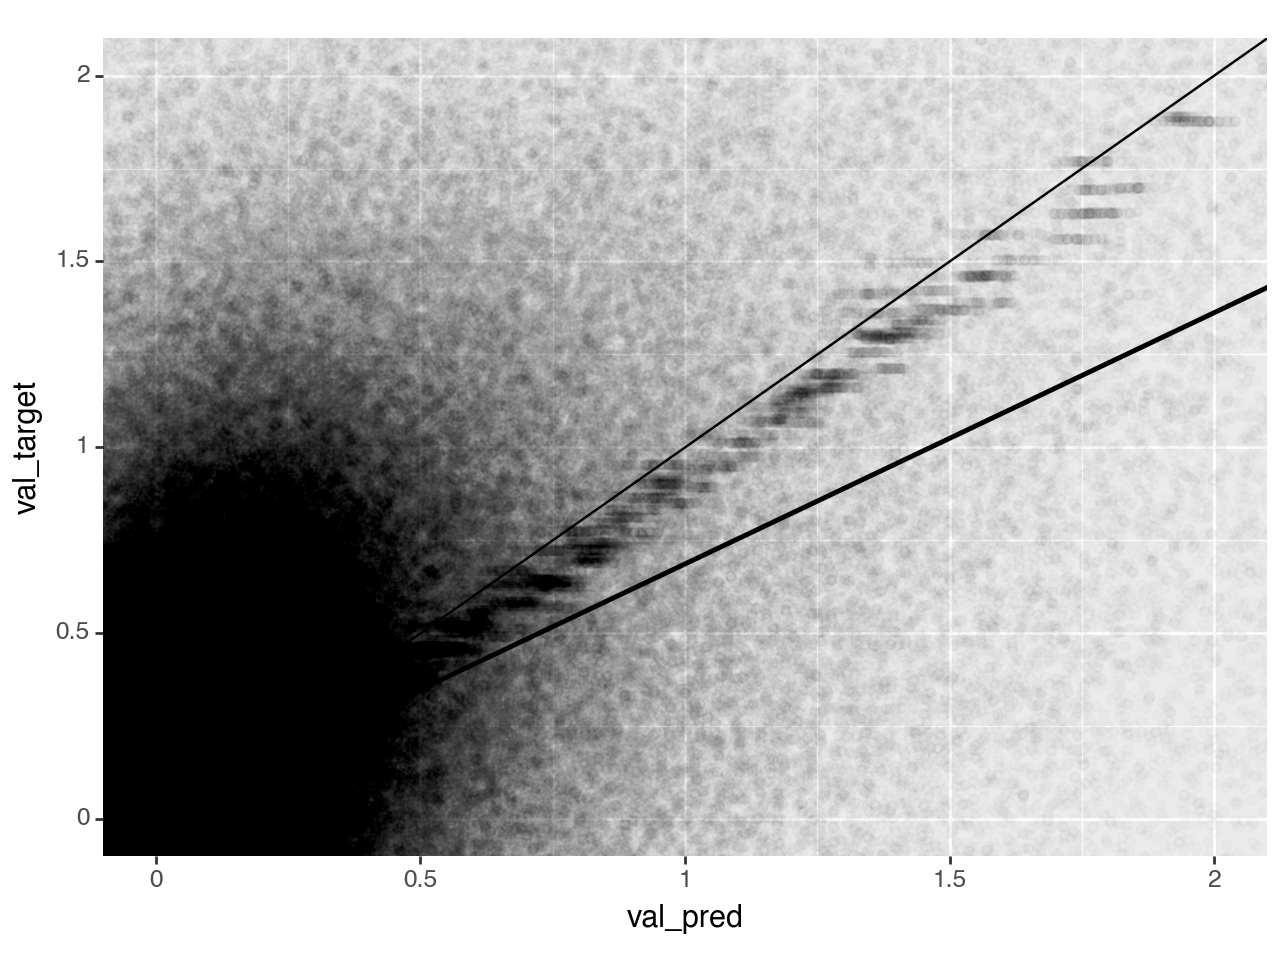

<Figure Size: (640 x 480)>

In [12]:
with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["cell_line_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["CERES_score"]))
        mu = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = mu.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
result = pd.DataFrame({
    "val_pred": val_pred,
    "val_target": val_target})
print("r2score: ", r2_score(val_target, val_pred))
plot = ggplot(result)
plot += geom_point(aes("val_pred", "val_target"), alpha = 0.01)
plot += coord_cartesian(ylim=(0, 2), xlim=(0,2))
plot += geom_smooth(aes("val_pred", "val_target"))
plot += geom_abline(intercept = 0, slope = 1)
plot

In [18]:
#export the gene embedding

export_path = "DepMap_d128.tsv"
model.gene_emb.get_emb_table().to_csv(export_path, sep="\t")


## exploring the gene embedding

In [14]:
%matplotlib inline

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: >

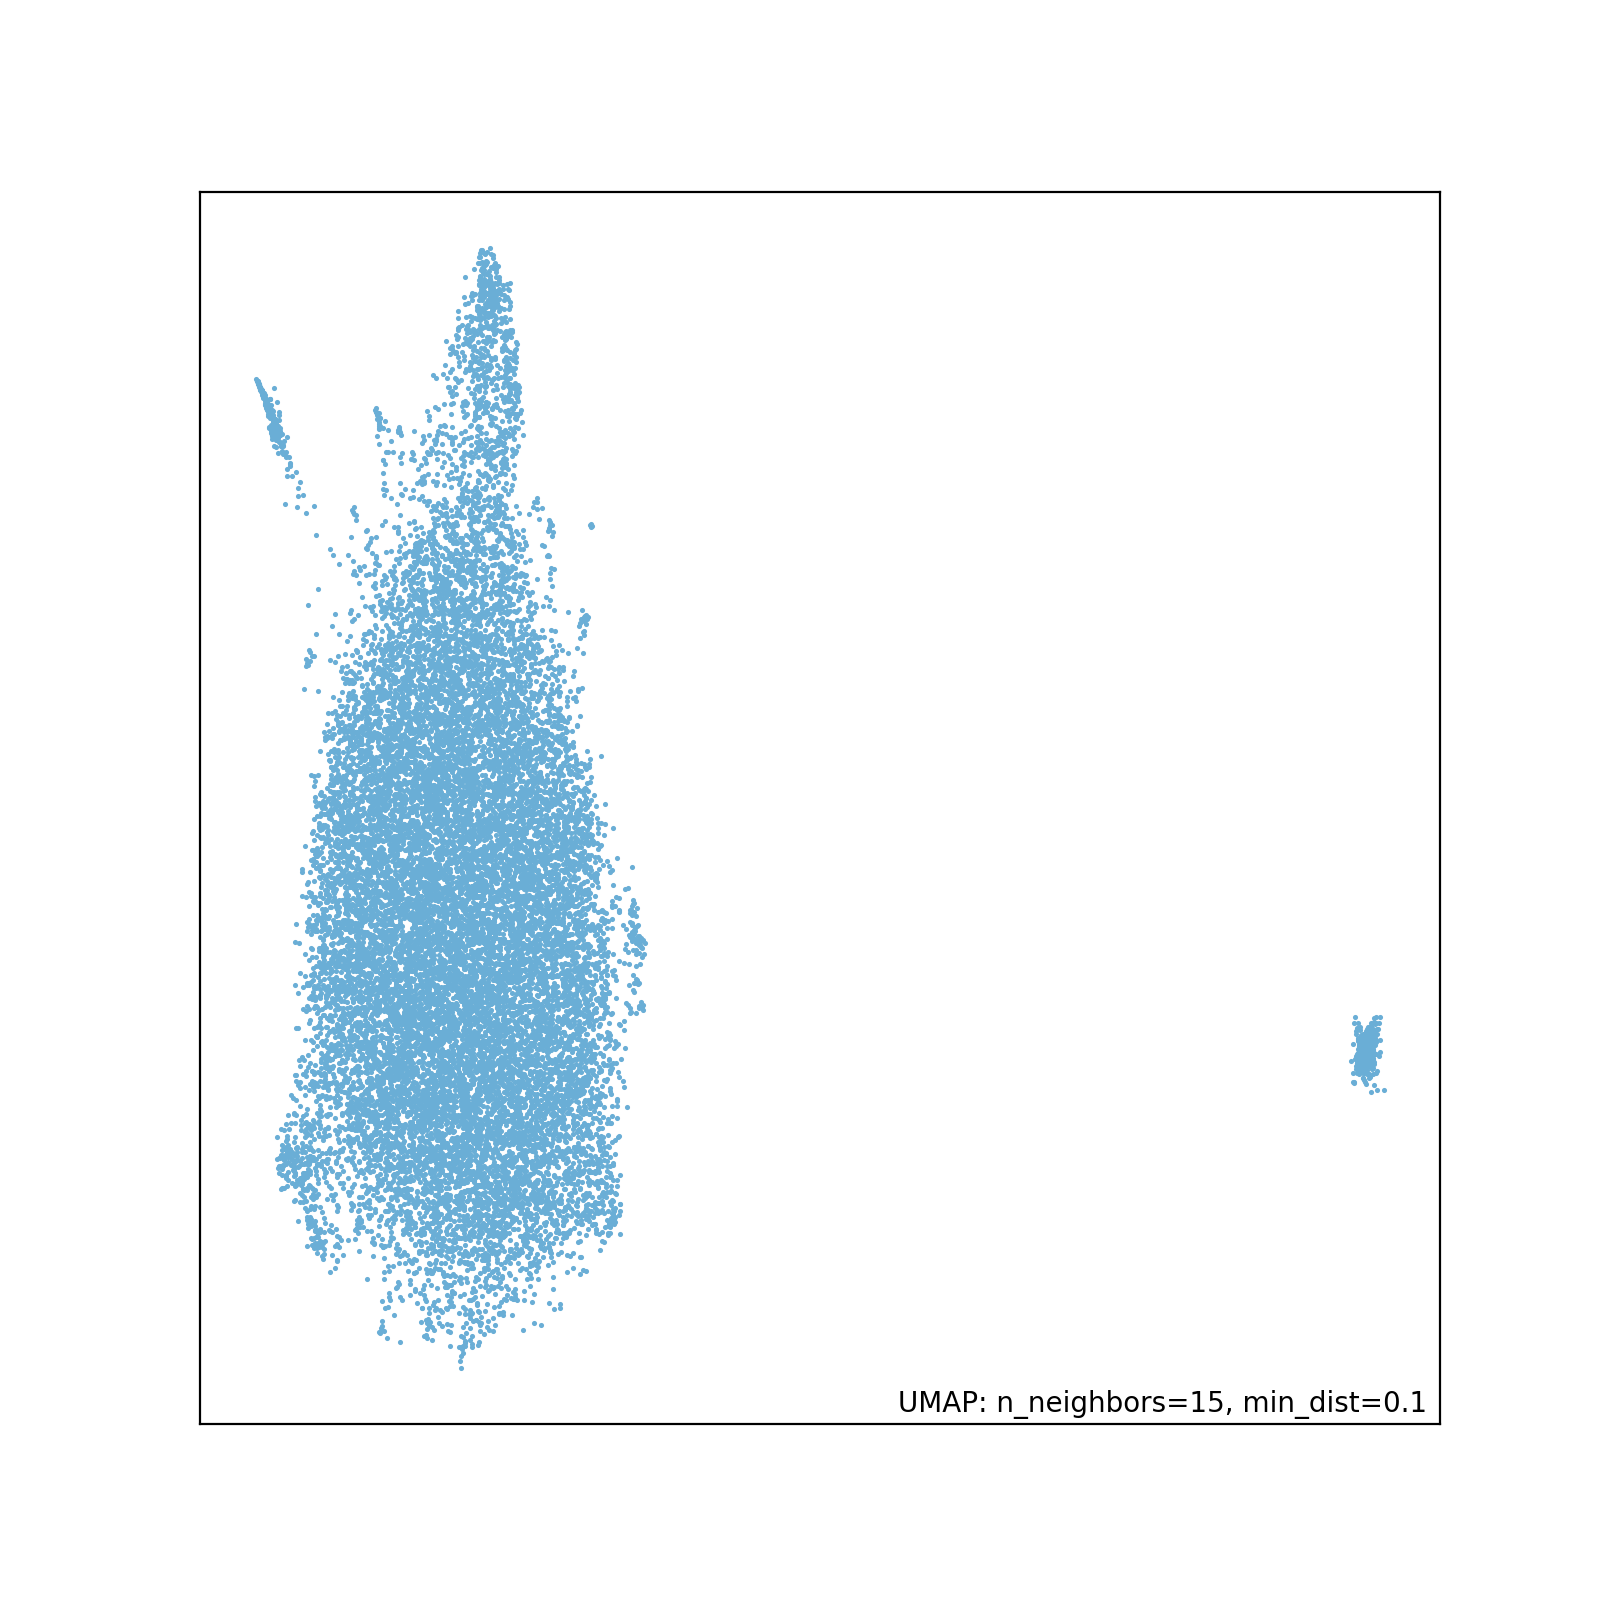

In [15]:
#the UMAP of the gene embedding
import umap.plot as umap_plot
import umap
emb_umap = umap.UMAP().fit(model.gene_emb.get_emb_table())
umap.plot.points(emb_umap)

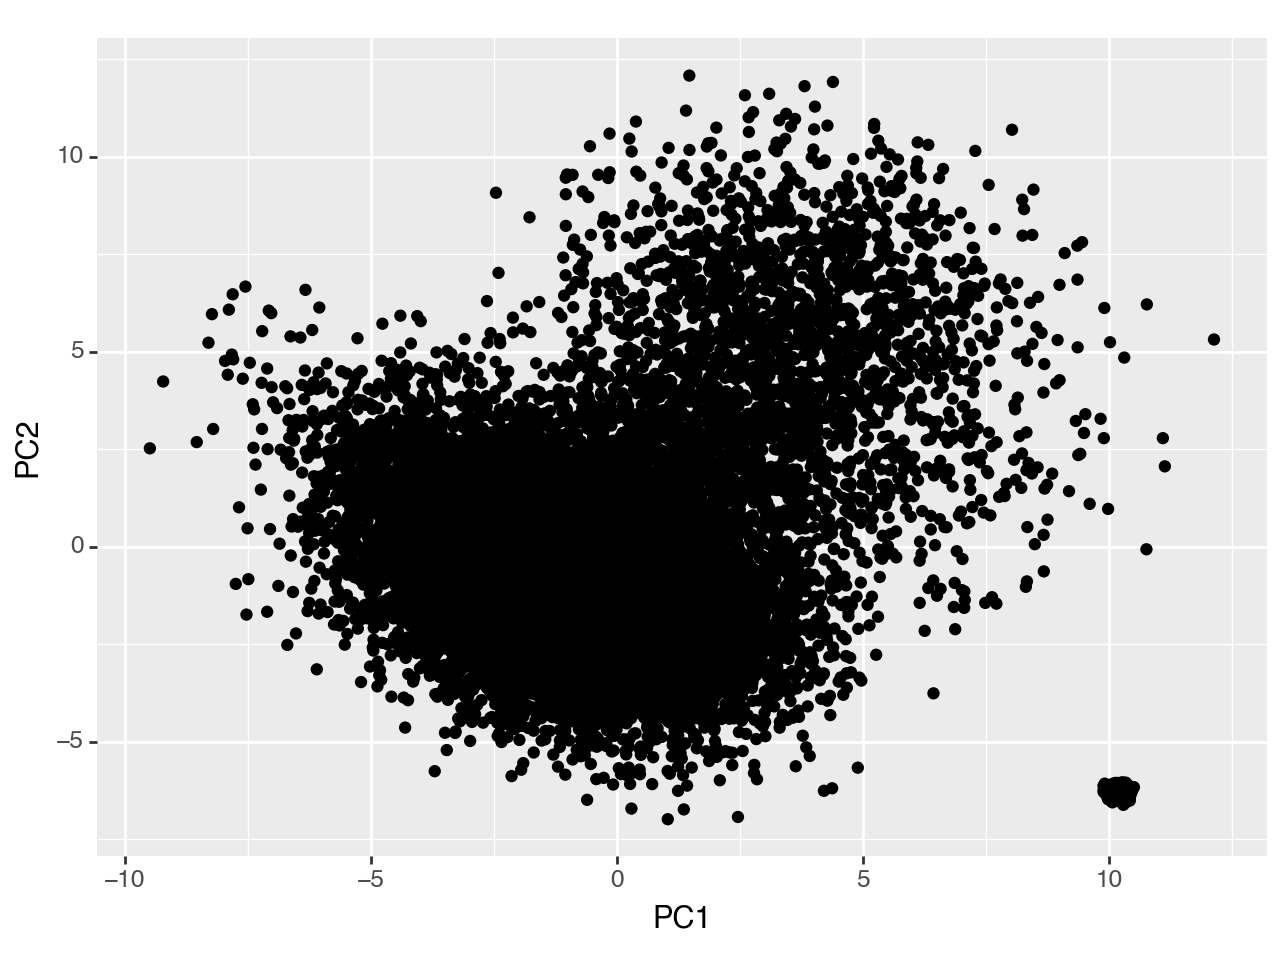

<Figure Size: (640 x 480)>

In [16]:
#the principle components
from sklearn.decomposition import PCA
pca = PCA(2)
pcs = pca.fit_transform(model.gene_emb.get_emb_table())
df_pcs = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
plot = ggplot(df_pcs) + geom_point(aes("PC1", "PC2"))
plot